# Setup

In [ ]:
import tensorflow as tf           # Tensorflow
import numpy as np                # Numpy
import matplotlib                # Matplotlib
import matplotlib.pyplot as plt   # Pyplot

# Versions:
print("TensorFlow: ", tf.__version__)           # Tensorflow version
print("Numpy     : ", np.__version__)                # Numpy Version
print("Matplotlib: ", matplotlib.__version__)   # Matplotlib version

TensorFlow:  2.19.0
Numpy     :  2.0.2
Matplotlib:  3.10.0


# Hyperparameters

In [ ]:
A = 1               # Generic Ampltitude
m = 2               # TEmn
n = 1               # TEmn
a = 0.05            # Width
b = 0.03            # Lenght
f = 10e9            # Operation Frequency
N_data = 5000  # Number of data trainning points
N_pde = 1000 # Number of pde trainning points
N_bc = 500 # Number of boundary conditions trainning points
lambda_data = 1 # Data loss weight
lambda_pde = 1e-10 # PDE loss weight
lambda_bc = 2e-9# Boundary condition loss weight

# Derivated parameters

In [ ]:
mu0 = 4*np.pi*1e-7
eps0 = 8.854187817e-12
c0 = 1/np.sqrt(mu0*eps0)
N_side = N_bc // 4 # Numer of points per side
k = 2*np.pi*f/c0       # Vaccum wavenumber
kx = m * np.pi / a
ky = n * np.pi / b
beta_squared = k**2 - kx**2 - ky**2
print(beta_squared)

17168.069403254194


# Data generation

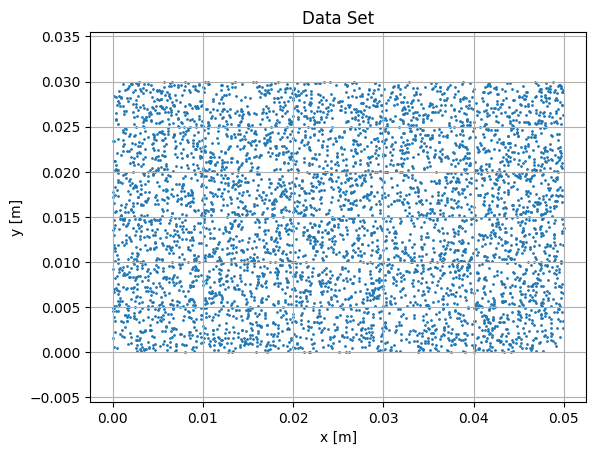

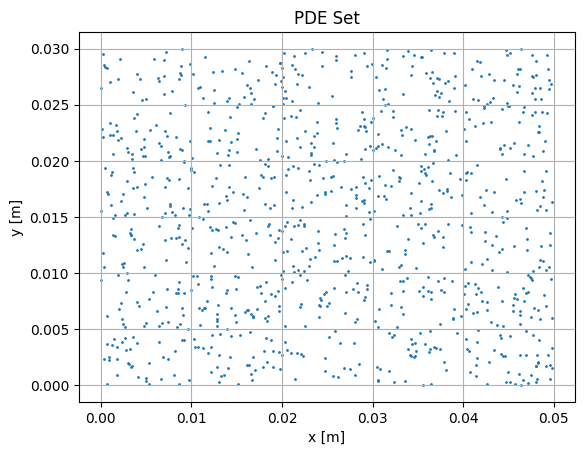

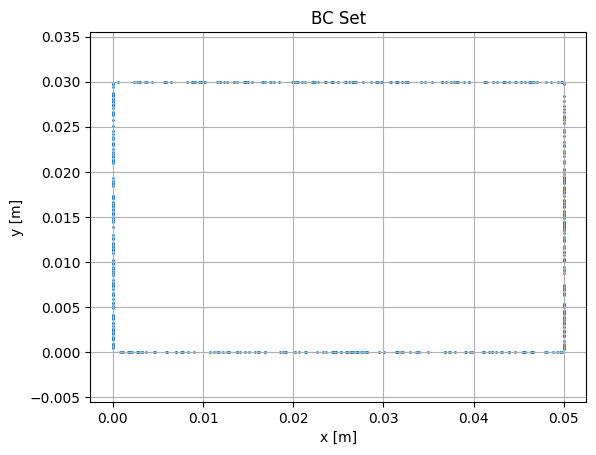

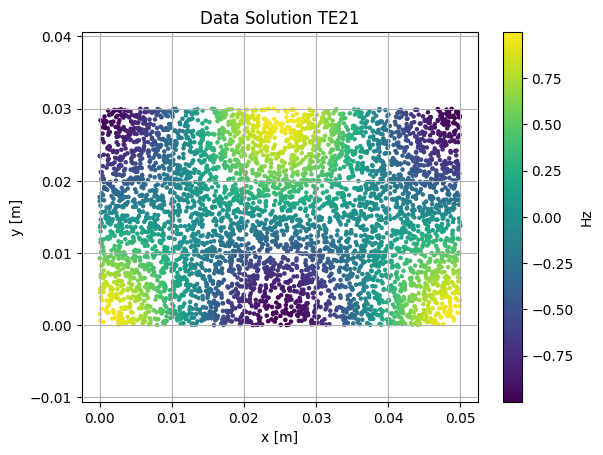

In [ ]:
def Hz_analytical(x, y):
  return A*np.cos(m*np.pi*x/a)*np.cos(n*np.pi*y/b)
# Data:
x = np.random.uniform(0, a, N_data) # x axis points
y = np.random.uniform(0, b, N_data) # y axis points
xy = np.stack([x, y], axis=1)       # (x, y) points
# PDE:
x_pde = np.random.uniform(0, a, N_pde) # x axis points
y_pde = np.random.uniform(0, b, N_pde) # y axis points
xy_pde = np.stack([x_pde, y_pde], axis=1)       # (x, y) points
# BC:
x0 = np.zeros((N_side, 1))    # x = 0
xa = a * np.ones((N_side, 1)) # x = a
y0 = np.zeros((N_side, 1))    # y = 0
ya = b * np.ones((N_side, 1)) # y = b
l1 = np.hstack( [np.random.uniform(0, a, (N_side, 1)), y0] )   # (x, 0)
l2 = np.hstack( [np.random.uniform(0, a, (N_side, 1)), ya] )   # (x, b)
l3 = np.hstack( [x0, np.random.uniform(0, b, (N_side, 1))] )   # (0, y)
l4 = np.hstack( [xa, np.random.uniform(0, b, (N_side, 1))] )   # (a, y)
xy_bc = np.vstack( [l1, l2, l3, l4] ) # Pontos das bordas
# Solution:
Hz_true = Hz_analytical(x, y) # Analytical solution
# Ploting the trainning set
# Data:
plt.figure()
plt.scatter(xy[:,0], xy[:,1], s=1)
plt.title("Data Set")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.grid(True)
plt.axis('equal')
plt.show()
# PDE:
plt.figure()
plt.scatter(xy_pde[:,0], xy_pde[:,1], s=1)
plt.title("PDE Set")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.grid(True)

# BC:
plt.figure()
plt.scatter(xy_bc[:,0], xy_bc[:,1], s=1)
plt.title("BC Set")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.grid(True)
plt.axis('equal')
plt.show()
# Analytical Hz:
plt.figure()
plt.scatter(xy[:,0], xy[:,1], c=Hz_true, cmap='viridis', s=5)
plt.colorbar(label='Hz')
plt.title("Data Solution TE{}{}".format(m, n))
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.axis('equal')
plt.grid(True)
plt.show()
# Casting to tensors:
xy_tf = tf.convert_to_tensor(xy, dtype=tf.float32)
xy_pde_tf = tf.convert_to_tensor(xy_pde, dtype=tf.float32)
xy_bc_tf = tf.convert_to_tensor(xy_bc, dtype=tf.float32)
Hz_true_tf = tf.convert_to_tensor(Hz_true.reshape(-1, 1), dtype=tf.float32)

# PINN

In [ ]:
class PINN(tf.keras.Model):
  def __init__(self, n_hidden_layers, n_neurons):
    super(PINN, self).__init__()
    self.hidden = [ tf.keras.layers.Dense( n_neurons, activation=tf.math.sin) for _ in range(n_hidden_layers)] # Hidden layers
    self.out = tf.keras.layers.Dense(1, activation=None, dtype = tf.float32) # Output layer

  def call(self, inputs):
    x = inputs
    for layer in self.hidden:
      x = layer(x)
    return self.out(x)
# Instantiate the model:
model = PINN( n_hidden_layers=4, n_neurons=64) # 4 hidden layers, 50 neurons per layer
# Model information:
#model.build(input_shape=(None, 2))  # Input dimension = 2
#model.summary()

# Loss

In [ ]:
def residue(model, xy): # Calcultates de Helhomtz Residue
  with tf.GradientTape(persistent=True) as tape2:
    tape2.watch(xy)
    with tf.GradientTape(persistent=True) as tape1:
      tape1.watch(xy)
      Hz = model(xy)
    grad = tape1.gradient(Hz, xy)  # [dHz/dx, dHz/dy]
    dHz_dx = grad[:, 0:1]
    dHz_dy = grad[:, 1:2]
    d2Hz_dxx = tape2.gradient(dHz_dx, xy)[:, 0:1]
    d2Hz_dyy = tape2.gradient(dHz_dy, xy)[:, 1:2]
    del tape1
    del tape2
  res = d2Hz_dxx + d2Hz_dyy + (k**2 - beta_squared) * Hz
  return res

def loss_bc(model, xy_bc_tf):
  with tf.GradientTape() as tape:
    tape.watch(xy_bc_tf)
    Hz = model(xy_bc_tf)
  grads = tape.gradient(Hz, xy_bc_tf)

  # x = 0 e x = a → dHz/dx
  # y = 0 e y = b → dHz/dy

  # Points per side:
  dHz_dx_x0 = grads[:N_side, 0:1]
  dHz_dx_xa = grads[N_side:2*N_side, 0:1]
  dHz_dy_y0 = grads[2*N_side:3*N_side, 1:2]
  dHz_dy_yb = grads[3*N_side:, 1:2]

  # Loss de contorno: MSE das derivadas
  loss_boundary = (
      tf.reduce_mean(lambda_bc*tf.square(dHz_dx_x0)) +
      tf.reduce_mean(lambda_bc*tf.square(dHz_dx_xa)) +
      tf.reduce_mean(lambda_bc*tf.square(dHz_dy_y0)) +
      tf.reduce_mean(lambda_bc*tf.square(dHz_dy_yb))
  )

  return loss_boundary


def loss(model, xy_dataset, xy_pde, xy_bc):
  res = residue(model, xy_pde) # Calculates the residue
  boundary_loss = loss_bc(model, xy_bc)
  loss_pde = tf.reduce_mean(lambda_pde*tf.square(res)) # Calculates the pde loss
  loss_data = tf.reduce_mean(lambda_data*tf.square(model(xy_dataset) - Hz_true_tf)) # Calculates the data loss
  total_loss = loss_data + loss_pde + boundary_loss # Calculates the weighted total loss
  return loss_pde, loss_data, boundary_loss, total_loss

# Trainning

In [ ]:
@tf.function # Compiles in a tensorflow graph to performance
def train_step(model, xy_dataset, xy_pde, xy_bc,  optimizer):
  with tf.GradientTape() as tape: # Auto diferentitation recorded for back propagation
    loss_pde, loss_data, loss_bc, loss_value = loss(model, xy_dataset, xy_pde, xy_bc) # Calculates the loss
  grads = tape.gradient(loss_value, model.trainable_variables)
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss_pde, loss_data, loss_bc, loss_value

epochs = 10_000
learning_rate = 0.01
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss_history = [] # Loss history
loss_pde_history = [] # PDE loss history
for epoch in range(epochs):
    loss_pde, loss_data, loss_bc, loss_value = train_step(model, xy_tf, xy_pde_tf, xy_bc_tf, optimizer)
    loss_history.append(loss_value) # Log total loss
    loss_pde_history.append(loss_pde)
    if epoch % 500 == 0 or epoch == epochs-1:
        print(f"Epoch {epoch}, PDE Loss: {loss_pde.numpy():.5f}, Data Loss: {loss_data.numpy():.5f}, BC Loss: {loss_bc.numpy():.5f}, Total Loss: {loss_value.numpy():.5f}")


Epoch 0, PDE Loss: 0.00000, Data Loss: 0.25000, BC Loss: 0.00000, Total Loss: 0.25000
Epoch 500, PDE Loss: 0.00002, Data Loss: 0.24979, BC Loss: 0.00000, Total Loss: 0.24981
Epoch 1000, PDE Loss: 0.00002, Data Loss: 0.24979, BC Loss: 0.00000, Total Loss: 0.24981
Epoch 1500, PDE Loss: 0.00002, Data Loss: 0.24979, BC Loss: 0.00000, Total Loss: 0.24981
Epoch 2000, PDE Loss: 0.00002, Data Loss: 0.24979, BC Loss: 0.00000, Total Loss: 0.24981
Epoch 2500, PDE Loss: 0.00002, Data Loss: 0.24979, BC Loss: 0.00000, Total Loss: 0.24981
Epoch 3000, PDE Loss: 0.00002, Data Loss: 0.24981, BC Loss: 0.00000, Total Loss: 0.24983
Epoch 3500, PDE Loss: 0.00004, Data Loss: 0.24996, BC Loss: 0.00000, Total Loss: 0.25000
Epoch 4000, PDE Loss: 0.00002, Data Loss: 0.24979, BC Loss: 0.00000, Total Loss: 0.24981
Epoch 4500, PDE Loss: 0.00002, Data Loss: 0.24985, BC Loss: 0.00000, Total Loss: 0.24987
Epoch 5000, PDE Loss: 0.00002, Data Loss: 0.24980, BC Loss: 0.00000, Total Loss: 0.24982
Epoch 5500, PDE Loss: 0.0

# Results

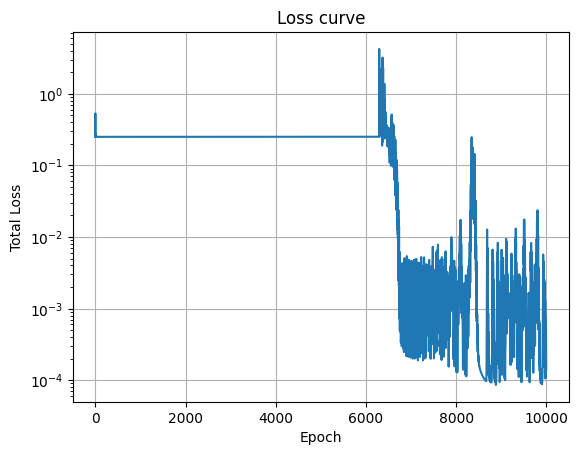

<Figure size 1200x500 with 0 Axes>

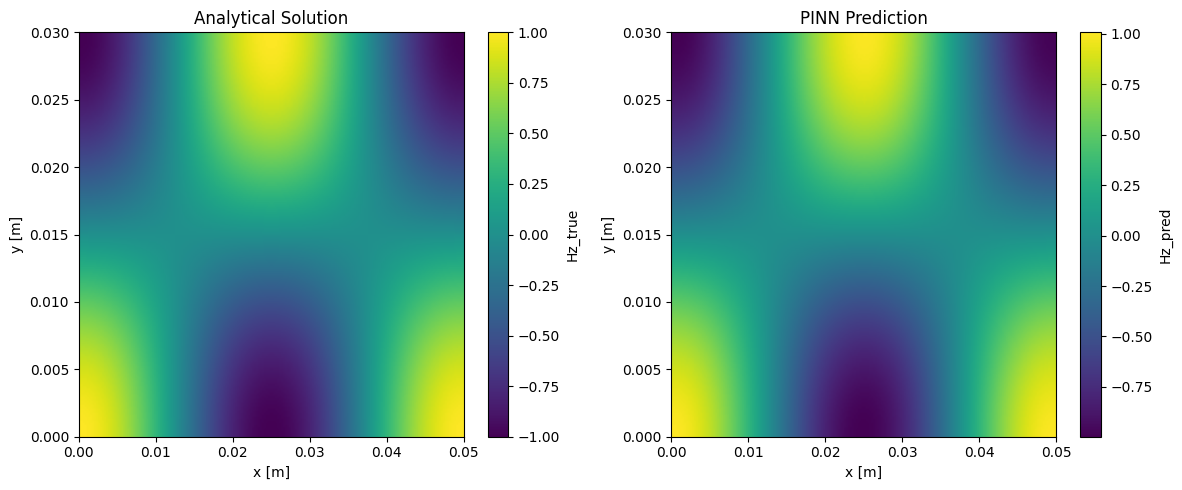

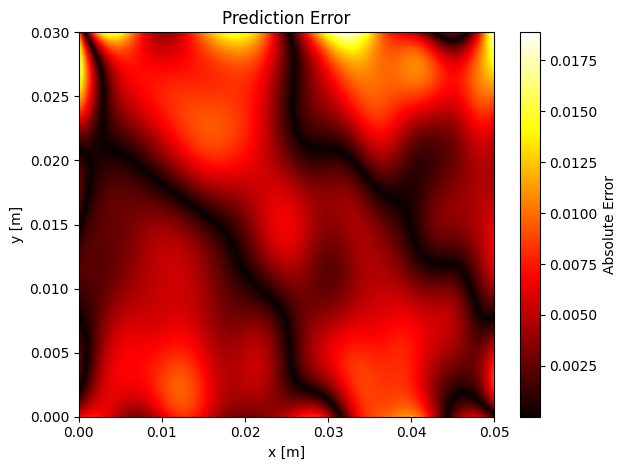

In [ ]:
Hz_pred_tf = model(xy_tf)
Hz_pred = Hz_pred_tf.numpy().flatten()

# Loss curve:
plt.figure()
plt.plot(loss_history)
plt.title("Loss curve")
plt.xlabel("Epoch")
plt.ylabel("Total Loss")
plt.yscale("log")
plt.grid(True)
plt.show()


plt.figure(figsize=(12, 5))


# Analytical solution x PINN Predicition

Nx, Ny = 200, 200  # resolução da imagem
x_grid = np.linspace(0, a, Nx)
y_grid = np.linspace(0, b, Ny)
X, Y = np.meshgrid(x_grid, y_grid)
xy_grid = np.stack([X.flatten(), Y.flatten()], axis=1)  # shape: (Nx*Ny, 2)
# Anakytical solution:
Hz_true_grid = Hz_analytical(X.flatten(), Y.flatten()).reshape(Ny, Nx)

# PINN predction:
xy_grid_tf = tf.convert_to_tensor(xy_grid, dtype=tf.float32)
Hz_pred_grid = model(xy_grid_tf).numpy().reshape(Ny, Nx)
plt.figure(figsize=(12, 5))

# Solução analítica
plt.subplot(1, 2, 1)
plt.imshow(Hz_true_grid, extent=[0, a, 0, b], origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label="Hz_true")
plt.title("Analytical Solution")
plt.xlabel("x [m]")
plt.ylabel("y [m]")

# Previsão do modelo
plt.subplot(1, 2, 2)
plt.imshow(Hz_pred_grid, extent=[0, a, 0, b], origin='lower', cmap='viridis', aspect='auto')
plt.colorbar(label="Hz_pred")
plt.title("PINN Prediction")
plt.xlabel("x [m]")
plt.ylabel("y [m]")

plt.tight_layout()
plt.show()
# Absolute error:
Hz_error_grid = np.abs(Hz_true_grid - Hz_pred_grid)

plt.figure()
plt.imshow(Hz_error_grid, extent=[0, a, 0, b], origin='lower', cmap='hot', aspect='auto')
plt.colorbar(label="Absolute Error")
plt.title("Prediction Error")
plt.xlabel("x [m]")
plt.ylabel("y [m]")
plt.tight_layout()
plt.show()